In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from data import data_preprocess
from evaluation import metrics
from model import end2end, end2end_crps

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('housing')

In [3]:
end2end_model = end2end.train_model(x_train, y_train, n_epoch = 1000, hidden_layers = [30, 30, 30], learning_rate = 0.005, exp_decay = .995)

initial loss:  810.475830078125
final loss:  2.522498846054077


End2end test MAPE:  0.12194069


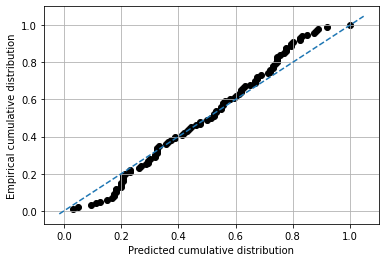

End2end test calibration error when step size is 0.001:  2.7966733434114395
End2end test calibration error when step size is 0.01:  0.27498740236835484
End2end test calibration error when step size is 0.1:  0.023456790123456805


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [3]:
end2end_model = end2end_crps.train_model(x_train, y_train, n_epoch = 1000, hidden_layers = [30, 30, 30], learning_rate = 0.005, exp_decay = .995)

initial loss:  824.6136474609375
final loss:  2.7213134765625


End2end test MAPE:  0.12865101
End2end test RMSE:  3.8180594


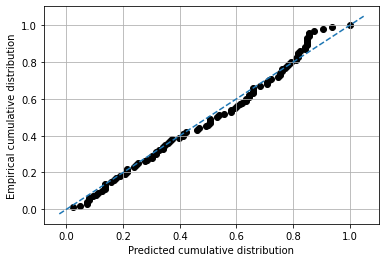

End2end test calibration error when step size is 0.001:  1.1256317712270096
End2end test calibration error when step size is 0.01:  0.11095364071554552
End2end test calibration error when step size is 0.1:  0.006449987402368353


In [4]:
mean_pred, var_pred = end2end_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()

print('End2end test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('End2end test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('End2end test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('End2end test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('End2end test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))